In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import xgboost as xgb
import optuna

df = pd.read_csv('AmesHousing.csv', sep='\t')
pd.set_option('display.max_columns', None)
new_df = df.assign(hasBasement = df['Total Bsmt SF'] > 0)
new_df = new_df.assign(hasGarage = df['Garage Area'] > 0)
new_df = new_df.assign(hasFireplace = df['Fireplaces'] > 0)
new_df = new_df.assign(hasPool = df['Pool Area'] > 0)
new_df = new_df.assign(TotalSF = (df['Total Bsmt SF'].fillna(0) + df['Gr Liv Area'].fillna(0)))
new_df = new_df.assign(TotalBath = (df['Bsmt Full Bath'].fillna(0) + 0.5 * df['Bsmt Half Bath'].fillna(0) + 
                                    df['Full Bath'].fillna(0) + 0.5 * df['Half Bath'].fillna(0)))
new_df = new_df.assign(TotalPorchSF = df['Open Porch SF'] + df['Enclosed Porch'] + df['3Ssn Porch'] + df['Screen Porch'])
new_df = new_df.assign(Positive_Off_Site = (df['Condition 2'] == 'PosN') | (df['Condition 2'] == 'PosA'))
new_df = new_df.assign(hasFence = df['Fence'].notnull())
new_df.drop(columns=['Total Bsmt SF', 'Fireplaces',
                      'Pool Area', 'Bsmt Exposure', 'Bsmt Half Bath',
                        'Bsmt Full Bath', 'BsmtFin Type 1', 'BsmtFin Type 2',
                          'Bsmt Exposure', 'Lot Config', 'Condition 2',
                            'Garage Type', 'Garage Finish', 'Garage Qual',
                              'Pool QC', 'Fence', 'Lot Shape', 'Land Slope',
                                'Fireplace Qu', 'Yr Sold',
                                  'Mo Sold', 'Order', '1st Flr SF', '2nd Flr SF'
                                  , 'Garage Yr Blt', 'Garage Cond', 'Wood Deck SF'
                                  , 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
                                  'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Low Qual Fin SF', 'PID']
                                    ,inplace=True)
new_df = new_df[new_df['Electrical'].notnull()]

print(new_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2929 entries, 0 to 2929
Data columns (total 56 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MS SubClass        2929 non-null   int64  
 1   MS Zoning          2929 non-null   object 
 2   Lot Frontage       2439 non-null   float64
 3   Lot Area           2929 non-null   int64  
 4   Street             2929 non-null   object 
 5   Alley              198 non-null    object 
 6   Land Contour       2929 non-null   object 
 7   Utilities          2929 non-null   object 
 8   Neighborhood       2929 non-null   object 
 9   Condition 1        2929 non-null   object 
 10  Bldg Type          2929 non-null   object 
 11  House Style        2929 non-null   object 
 12  Overall Qual       2929 non-null   int64  
 13  Overall Cond       2929 non-null   int64  
 14  Year Built         2929 non-null   int64  
 15  Year Remod/Add     2929 non-null   int64  
 16  Roof Style         2929 non-n

<Axes: >

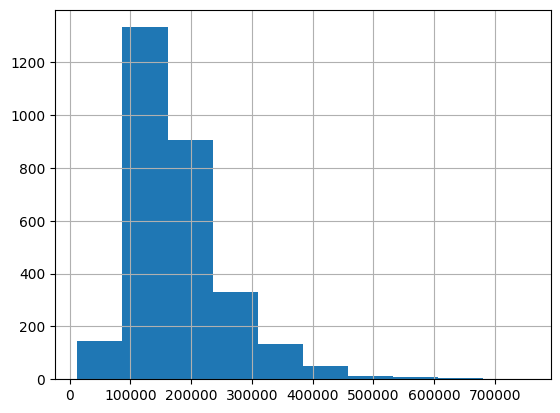

In [2]:
new_df['SalePrice'].hist()

In [3]:
def categorize_price(price):
    if price < 100000:
        return 'Low'
    elif price < 175000:
        return 'Medium-Low'
    elif price < 300000:
        return 'Medium-High'
    else:
        return 'High'

new_df['PriceCategory'] = new_df['SalePrice'].apply(categorize_price)
print(new_df['PriceCategory'].value_counts().sort_index())

PriceCategory
High            238
Low             237
Medium-High    1002
Medium-Low     1452
Name: count, dtype: int64


In [4]:
X = new_df.drop(columns=['SalePrice', 'PriceCategory'])
y = new_df['PriceCategory']


ordinal_features = ['Utilities', 'Overall Qual', 'Overall Cond', 'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Heating QC','Kitchen Qual', 'Functional',
                    'Paved Drive']

nominal_features =['MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Land Contour', 'Neighborhood', 'Condition 1', 'Bldg Type', 'House Style', 'Roof Style',
                   'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Heating', 'Central Air', 'Misc Feature', 'Sale Type', 'Sale Condition', 'Electrical']


X_cat = X.copy()
bool_cols = X_cat.select_dtypes(include=['bool']).columns
X_cat[bool_cols] = X_cat[bool_cols].astype('object')

label_encoders = {}
for col in ordinal_features:
    if col in X_cat.columns:
        le = LabelEncoder()
        X_cat[col] = le.fit_transform(X_cat[col].astype(str))
        label_encoders[col] = le
    else:
        print(f"Ordinal column missing, skipping: {col}")

nominal_present = [c for c in nominal_features if c in X_cat.columns]
missing_nominal = [c for c in nominal_features if c not in X_cat.columns]
if len(missing_nominal) > 0:
    print(f"Skipping missing nominal columns: {missing_nominal}")
if len(nominal_present) > 0:
    X_cat[nominal_present] = X_cat[nominal_present].astype(str)
    X_nominal_dummies = pd.get_dummies(X_cat[nominal_present], prefix=nominal_present)
    X_cat = X_cat.drop(columns=nominal_present)
    X_processed = pd.concat([X_cat, X_nominal_dummies], axis=1)
else:
    X_processed = X_cat.copy()

if len(bool_cols) > 0:
    X_processed[bool_cols] = X_processed[bool_cols].astype(int)


X = X_processed

y_encoder = LabelEncoder()
y_encoded = y_encoder.fit_transform(y)

print(f"Number of features: {X.shape[1]}")
print(f"Number of classes: {len(np.unique(y_encoded))}")
print(f"Class labels: {y_encoder.classes_}")


Number of features: 209
Number of classes: 4
Class labels: ['High' 'Low' 'Medium-High' 'Medium-Low']


In [5]:
X_train_20_no, X_test_20_no, y_train_20_no, y_test_20_no = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=None
)

print(f"\nClass distribution in training set (no stratification):")
unique, counts = np.unique(y_train_20_no, return_counts=True)
for cls, cnt in zip(y_encoder.classes_, counts):
    print(f"  {cls}: {cnt} ({cnt/len(y_train_20_no)*100:.1f}%)")

xgb_model_20_no_strat = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y_encoded)),
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42,
    eval_metric='mlogloss'
)

xgb_model_20_no_strat.fit(X_train_20_no, y_train_20_no)
y_pred_20_no_strat = xgb_model_20_no_strat.predict(X_test_20_no)

print(f"\nAccuracy:  {accuracy_score(y_test_20_no, y_pred_20_no_strat):.4f}")
print(f"Precision: {precision_score(y_test_20_no, y_pred_20_no_strat, average='weighted'):.4f}")
print(f"Recall:    {recall_score(y_test_20_no, y_pred_20_no_strat, average='weighted'):.4f}")
print(f"F1 Score:  {f1_score(y_test_20_no, y_pred_20_no_strat, average='weighted'):.4f}")


Class distribution in training set (no stratification):
  High: 189 (8.1%)
  Low: 185 (7.9%)
  Medium-High: 809 (34.5%)
  Medium-Low: 1160 (49.5%)

Accuracy:  0.8720
Precision: 0.8713
Recall:    0.8720
F1 Score:  0.8715


In [6]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_20_no, y_train_20_no, test_size=0.2, random_state=42, stratify=y_train_20_no
)
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 2000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.3, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
    
    y_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_pred, average='weighted')
    return f1

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("Best F1-score:", study.best_value)
print("Best parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-14 17:59:17,298] A new study created in memory with name: no-name-2689539f-ae05-4a03-8755-d7bbe4d65e96


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-14 17:59:21,435] Trial 0 finished with value: 0.7830340831894613 and parameters: {'max_depth': 7, 'learning_rate': 0.2536999076681772, 'n_estimators': 1478, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.40921304830970556, 'colsample_bylevel': 0.40919616423534183, 'min_child_weight': 2, 'gamma': 8.661761457749352, 'reg_alpha': 6.011150117432088, 'reg_lambda': 7.080725777960454}. Best is trial 0 with value: 0.7830340831894613.
[I 2025-11-14 17:59:26,829] Trial 1 finished with value: 0.8032449807124277 and parameters: {'max_depth': 3, 'learning_rate': 0.2708160864249968, 'n_estimators': 1674, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.42727747704497043, 'colsample_bylevel': 0.4283831568974037, 'min_child_weight': 7, 'gamma': 5.247564316322379, 'reg_alpha': 4.319450186421157, 'reg_lambda': 2.9122914019804194}. Best is trial 1 with value: 0.8032449807124277.
[I 2025-11-14 17:59:29,432] Trial 2 finished with value: 0.8060053929693076 and parameters: {'max_dept

In [7]:
best_params = study.best_params.copy()

best_params.update({
    "objective": "multi:softprob",
    "num_class": len(np.unique(y_train_20_no)),
    "eval_metric": "mlogloss",
    "random_state": 42
})

final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train_20_no, y_train_20_no)

y_pred_final = final_model.predict(X_test_20_no)

acc = accuracy_score(y_test_20_no, y_pred_final)
prec = precision_score(y_test_20_no, y_pred_final, average='weighted')
rec = recall_score(y_test_20_no, y_pred_final, average='weighted')
f1 = f1_score(y_test_20_no, y_pred_final, average='weighted')

print(f"\nFinal model performance (using best Optuna parameters):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")



Final model performance (using best Optuna parameters):
Accuracy:  0.8788
Precision: 0.8784
Recall:    0.8788
F1 Score:  0.8786


In [8]:
import optuna.visualization as vis

fig1 = vis.plot_optimization_history(study)
fig1.show()

fig2 = vis.plot_param_importances(study)
fig2.show()

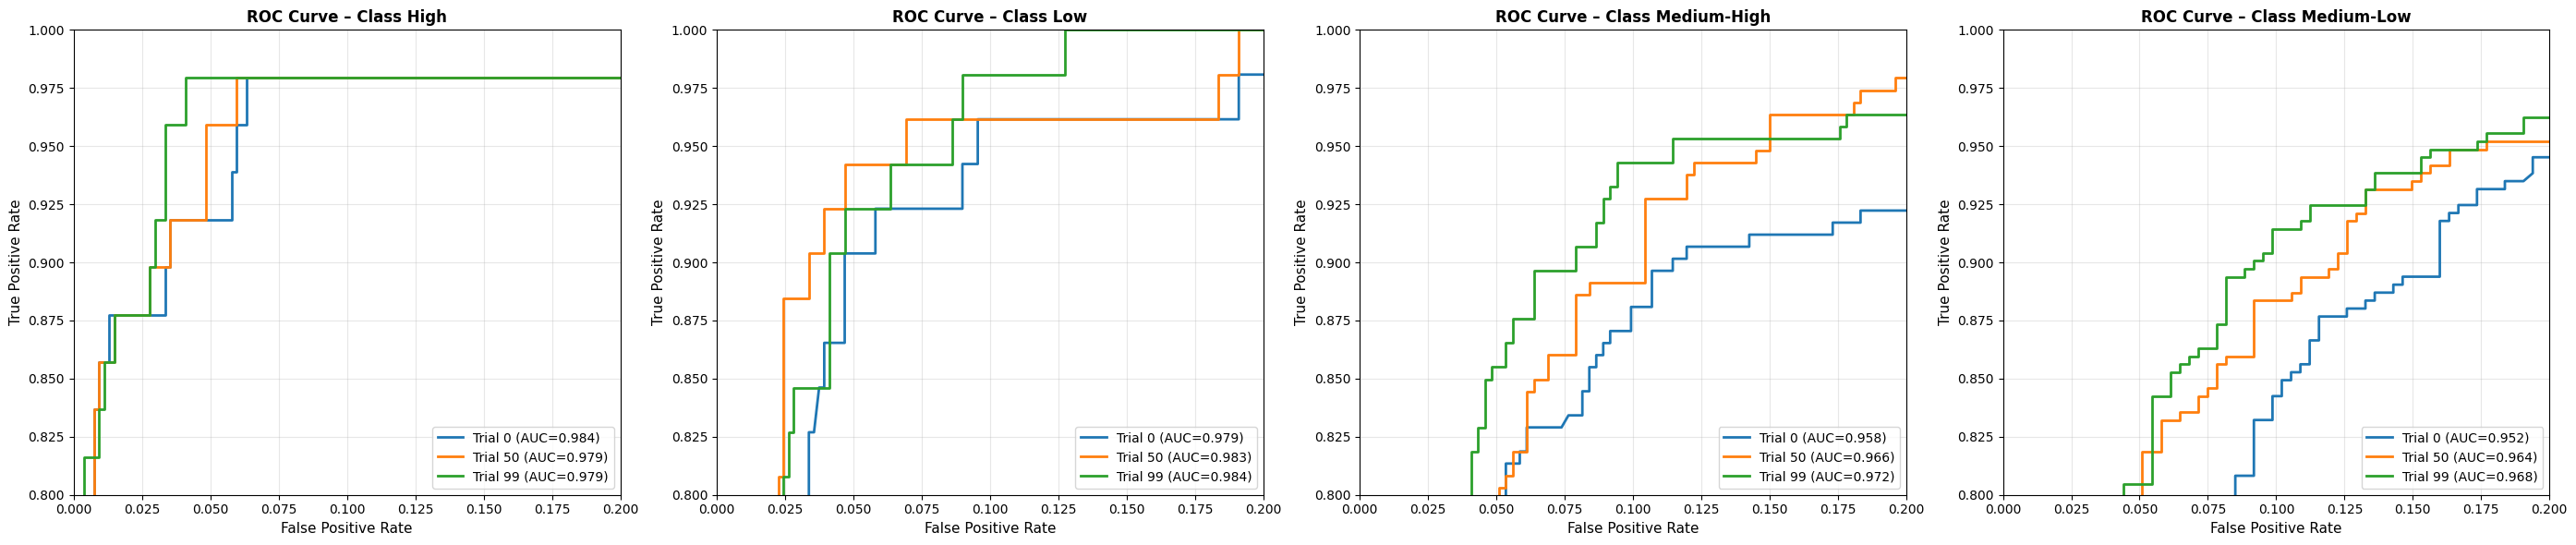

In [9]:
from sklearn.metrics import roc_curve, auc

trial_indices = [0, len(study.trials)//2, len(study.trials)-1]
n_classes = len(np.unique(y_test_20_no))
y_true_bin = np.zeros((len(y_test_20_no), n_classes))
for j, cls in enumerate(np.unique(y_test_20_no)):
    y_true_bin[:, j] = (y_test_20_no == cls).astype(int)

fig, axes = plt.subplots(1, n_classes, figsize=(7*n_classes, 6))
if n_classes == 1:
    axes = [axes]

for j in range(n_classes):
    class_name = y_encoder.inverse_transform([j])[0]
    ax = axes[j]

    for i in trial_indices:
        trial = study.trials[i]
        model = xgb.XGBClassifier(
            **trial.params.copy(),
            objective="multi:softprob",
            num_class=n_classes,
            eval_metric="mlogloss",
            random_state=42
        )
        model.fit(X_train_20_no, y_train_20_no)
        y_proba = model.predict_proba(X_test_20_no)

        fpr, tpr, _ = roc_curve(y_true_bin[:, j], y_proba[:, j])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f'Trial {i} (AUC={roc_auc:.3f})', linewidth=2)

    
    ax.set_title(f'ROC Curve – Class {class_name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('False Positive Rate', fontsize=11)
    ax.set_ylabel('True Positive Rate', fontsize=11)
    
    ax.set_xlim(0, 0.2)
    ax.set_ylim(0.8, 1.0)
    
    ax.legend(loc='lower right')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

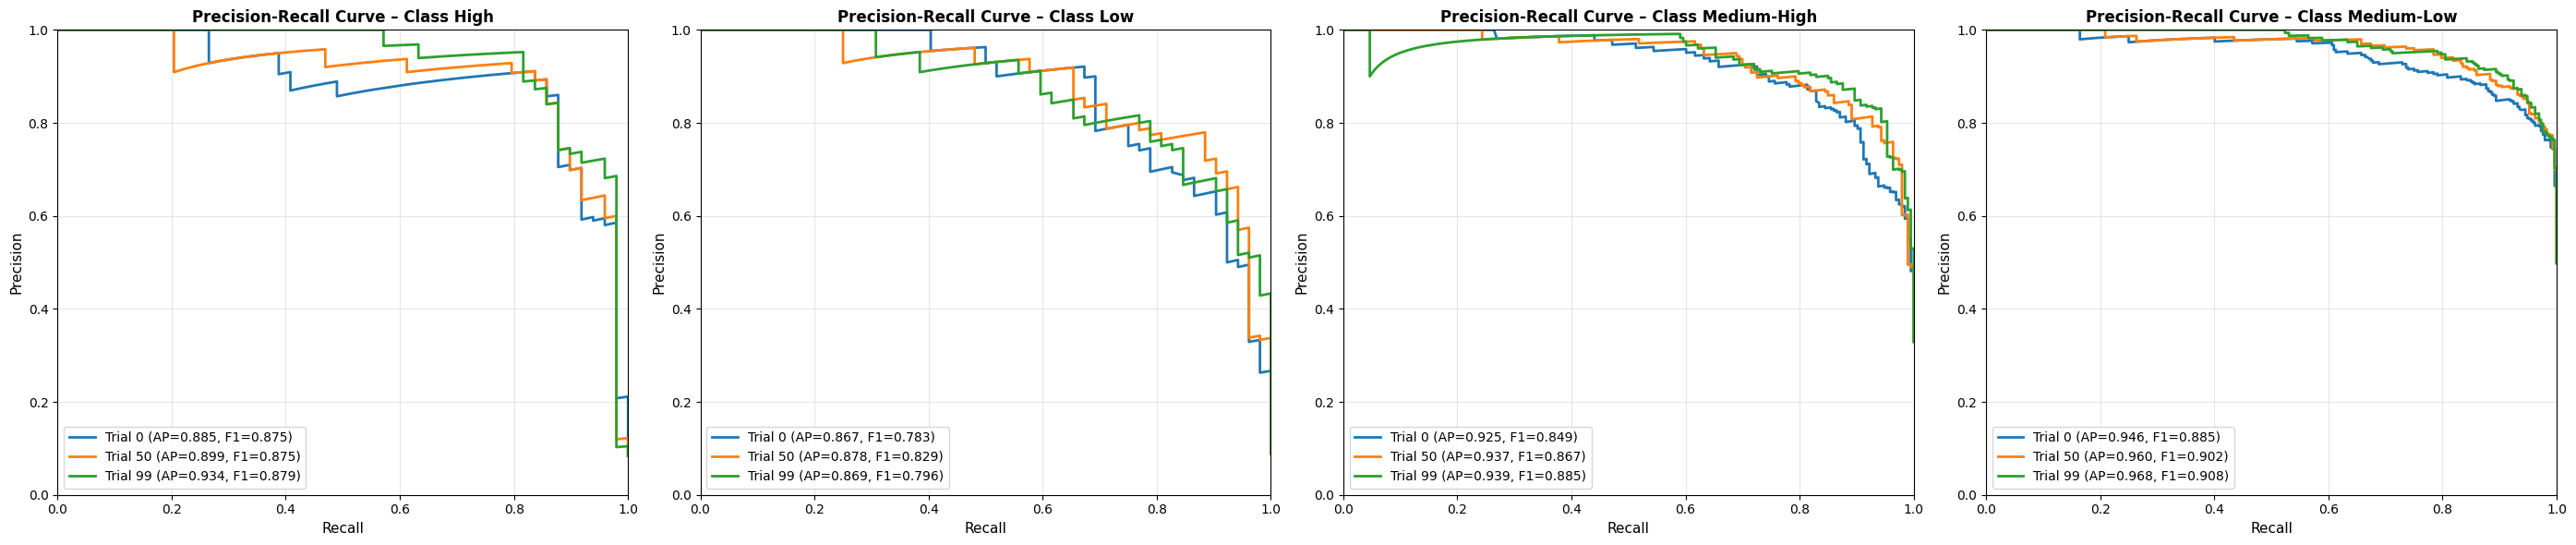

SUMMARY: Best F1 Thresholds per Class
High           : 0.6866
Low            : 0.2955
Medium-High    : 0.4195
Medium-Low     : 0.4990
SUMMARY: Average Precision Scores per Class
High           : 0.9061
Low            : 0.8712
Medium-High    : 0.9334
Medium-Low     : 0.9582


In [10]:
from sklearn.metrics import precision_recall_curve, average_precision_score

fig, axes = plt.subplots(1, n_classes, figsize=(7*n_classes, 6))
if n_classes == 1:
    axes = [axes]

best_thresholds_per_class = {}
ap_scores_per_class = {j: [] for j in range(n_classes)}

for j in range(n_classes):
    class_name = y_encoder.inverse_transform([j])[0]
    ax = axes[j]
    
    best_f1 = -1
    best_thr = 0.5

    for i in trial_indices:
        trial = study.trials[i]
        model = xgb.XGBClassifier(
            **trial.params.copy(),
            objective="multi:softprob",
            num_class=n_classes,
            eval_metric="mlogloss",
            random_state=42
        )
        model.fit(X_train_20_no, y_train_20_no)
        y_proba = model.predict_proba(X_test_20_no)

        precision, recall, thresholds = precision_recall_curve(y_true_bin[:, j], y_proba[:, j])
        ap = average_precision_score(y_true_bin[:, j], y_proba[:, j])
        ap_scores_per_class[j].append(ap)
        
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
        idx = np.argmax(f1_scores)
        
        if f1_scores[idx] > best_f1:
            best_f1 = f1_scores[idx]
            best_thr = thresholds[idx] if idx < len(thresholds) else 0.5

        ax.plot(recall, precision, label=f'Trial {i} (AP={ap:.3f}, F1={f1_scores[idx]:.3f})', linewidth=2)

    best_thresholds_per_class[class_name] = best_thr

    ax.set_title(f'Precision-Recall Curve – Class {class_name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Recall', fontsize=11)
    ax.set_ylabel('Precision', fontsize=11)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend(loc='best')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("SUMMARY: Best F1 Thresholds per Class")
for class_name, thr in best_thresholds_per_class.items():
    print(f'{class_name:15s}: {thr:.4f}')


print("SUMMARY: Average Precision Scores per Class")
for j in range(n_classes):
    class_name = y_encoder.inverse_transform([j])[0]
    avg_ap = np.mean(ap_scores_per_class[j])
    print(f'{class_name:15s}: {avg_ap:.4f}')

In [11]:
def predict_with_thresholds(model, X, thresholds_dict, class_names):
    y_proba = model.predict_proba(X)
    predictions = []
    
    for i in range(len(X)):
        scores = y_proba[i]
        adjusted_scores = []
        for j, class_name in enumerate(class_names):
            threshold = thresholds_dict.get(class_name, 0.5)
            adjusted_scores.append(scores[j] if scores[j] >= threshold else 0)
        
        predictions.append(np.argmax(adjusted_scores))
    
    return np.array(predictions)

y_pred_threshold = predict_with_thresholds(
    final_model, X_test_20_no, 
    best_thresholds_per_class, 
    y_encoder.classes_
)

print("\nPerformance with optimized thresholds:")
print(f"Accuracy:  {accuracy_score(y_test_20_no, y_pred_threshold):.4f}")
print(f"Precision: {precision_score(y_test_20_no, y_pred_threshold, average='weighted'):.4f}")
print(f"Recall:    {recall_score(y_test_20_no, y_pred_threshold, average='weighted'):.4f}")
print(f"F1 Score:  {f1_score(y_test_20_no, y_pred_threshold, average='weighted'):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_20_no, y_pred_threshold, target_names=y_encoder.classes_))



Performance with optimized thresholds:
Accuracy:  0.8788
Precision: 0.8784
Recall:    0.8788
F1 Score:  0.8786

Classification Report:
              precision    recall  f1-score   support

        High       0.85      0.84      0.85        49
         Low       0.82      0.77      0.79        52
 Medium-High       0.87      0.88      0.87       193
  Medium-Low       0.90      0.91      0.90       292

    accuracy                           0.88       586
   macro avg       0.86      0.85      0.85       586
weighted avg       0.88      0.88      0.88       586



In [12]:
from imblearn.over_sampling import SMOTE

X_train_filled = X_train_20_no.fillna(X_train_20_no.median(numeric_only=True)).fillna(0)

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_filled, y_train_20_no)

smote_model = xgb.XGBClassifier(**best_params)
smote_model.fit(X_train_bal, y_train_bal)

X_test_filled = X_test_20_no.fillna(X_test_20_no.median(numeric_only=True)).fillna(0)
y_pred_smote = smote_model.predict(X_test_filled)

from sklearn.metrics import classification_report
print("Performance after SMOTE balancing:")
print(classification_report(y_test_20_no, y_pred_smote, target_names=y_encoder.classes_))


acc = accuracy_score(y_test_20_no, y_pred_smote)
prec = precision_score(y_test_20_no, y_pred_smote, average='weighted')
rec = recall_score(y_test_20_no, y_pred_smote, average='weighted')
f1 = f1_score(y_test_20_no, y_pred_smote, average='weighted')

print(f"\nSMOTE model performance:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

Performance after SMOTE balancing:
              precision    recall  f1-score   support

        High       0.84      0.88      0.86        49
         Low       0.77      0.77      0.77        52
 Medium-High       0.87      0.87      0.87       193
  Medium-Low       0.90      0.90      0.90       292

    accuracy                           0.87       586
   macro avg       0.85      0.85      0.85       586
weighted avg       0.87      0.87      0.87       586


SMOTE model performance:
Accuracy:  0.8737
Precision: 0.8738
Recall:    0.8737
F1 Score:  0.8737


In [13]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_20_no), y=y_train_20_no)
weight_dict = {i: w for i, w in enumerate(class_weights)}

weight_dict_named = {y_encoder.classes_[i]: w for i, w in enumerate(class_weights)}
print("Class weights with names:", weight_dict_named)


weighted_model = xgb.XGBClassifier(**best_params)
sample_weights = np.array([weight_dict[y] for y in y_train_20_no])
weighted_model.fit(X_train_20_no, y_train_20_no, sample_weight=sample_weights)

y_pred_weighted = weighted_model.predict(X_test_20_no)
print("Performance using class weights:")
print(classification_report(y_test_20_no, y_pred_weighted, target_names=y_encoder.classes_))

acc = accuracy_score(y_test_20_no, y_pred_weighted)
prec = precision_score(y_test_20_no, y_pred_weighted, average='weighted')
rec = recall_score(y_test_20_no, y_pred_weighted, average='weighted')
f1 = f1_score(y_test_20_no, y_pred_weighted, average='weighted')

print(f"\nWeighted model performance:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

Class weights with names: {'High': np.float64(3.0992063492063493), 'Low': np.float64(3.1662162162162164), 'Medium-High': np.float64(0.7240420271940667), 'Medium-Low': np.float64(0.5049568965517242)}
Performance using class weights:
              precision    recall  f1-score   support

        High       0.79      0.90      0.84        49
         Low       0.68      0.81      0.74        52
 Medium-High       0.87      0.87      0.87       193
  Medium-Low       0.91      0.86      0.89       292

    accuracy                           0.86       586
   macro avg       0.81      0.86      0.83       586
weighted avg       0.87      0.86      0.86       586


Weighted model performance:
Accuracy:  0.8618
Precision: 0.8672
Recall:    0.8618
F1 Score:  0.8633


In [14]:
from sklearn.ensemble import VotingClassifier

models_to_ensemble = []

model1 = xgb.XGBClassifier(**best_params)
model1.fit(X_train_20_no, y_train_20_no)
models_to_ensemble.append(('optuna', model1))

model2 = xgb.XGBClassifier(**best_params)
X_train_filled = X_train_20_no.fillna(X_train_20_no.median(numeric_only=True)).fillna(0)
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_filled, y_train_20_no)
model2.fit(X_train_bal, y_train_bal)
models_to_ensemble.append(('smote', model2))

model3 = xgb.XGBClassifier(**best_params)
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_20_no), y=y_train_20_no)
weight_dict = {i: w for i, w in enumerate(class_weights)}
sample_weights = np.array([weight_dict[y] for y in y_train_20_no])
model3.fit(X_train_20_no, y_train_20_no, sample_weight=sample_weights)
models_to_ensemble.append(('weighted', model3))

ensemble = VotingClassifier(estimators=models_to_ensemble, voting='soft')
ensemble.fit(X_train_20_no, y_train_20_no)

y_pred_ensemble = ensemble.predict(X_test_20_no)
print("\nEnsemble Model Performance:")
print(classification_report(y_test_20_no, y_pred_ensemble, target_names=y_encoder.classes_))

acc = accuracy_score(y_test_20_no, y_pred_ensemble)
prec = precision_score(y_test_20_no, y_pred_ensemble, average='weighted')
rec = recall_score(y_test_20_no, y_pred_ensemble, average='weighted')
f1 = f1_score(y_test_20_no, y_pred_ensemble, average='weighted')

print(f"\nEnsemble model performance:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")




Ensemble Model Performance:
              precision    recall  f1-score   support

        High       0.85      0.84      0.85        49
         Low       0.82      0.77      0.79        52
 Medium-High       0.87      0.88      0.87       193
  Medium-Low       0.90      0.91      0.90       292

    accuracy                           0.88       586
   macro avg       0.86      0.85      0.85       586
weighted avg       0.88      0.88      0.88       586


Ensemble model performance:
Accuracy:  0.8788
Precision: 0.8784
Recall:    0.8788
F1 Score:  0.8786
